## Cobra sampling benchmark

This illustrates the new cobra sampling and gives some basic performance metrics.

### Generating samples

In [1]:
%matplotlib inline
from cobra.test import create_test_model
from cobra.flux_analysis.sampling import OptGPSampler, ARCHSampler
import pandas as pd

mod = create_test_model("textbook")      # 95 reactions

All the samplers implement thinning (only using every n samples) to avoid autocorrelation, we will start with versions without thinning to illustrate the basic performance.

In [2]:
arch = ARCHSampler(mod, thinning=1)

In [3]:
optgp = OptGPSampler(mod, processes=1, thinning=1)

In [4]:
arch_samples = arch.sample(1000)
arch_samples = pd.DataFrame(arch_samples, columns=[r.id for r in mod.reactions])

In [5]:
optgp_samples = optgp.sample(1000)
optgp_samples = pd.DataFrame(optgp_samples, columns=[r.id for r in mod.reactions])

We can also validate our samples. Using the validate method of the classes (`v` means valid, see docstring for more info).

In [6]:
from collections import Counter

print(Counter(arch.validate(arch_samples)))
print(Counter(optgp.validate(optgp_samples)))

Counter({'v': 1000})
Counter({'v': 1000})


### Autocorrelation

ARCH should perform a bit better since it does not used delayed updates as optGP..

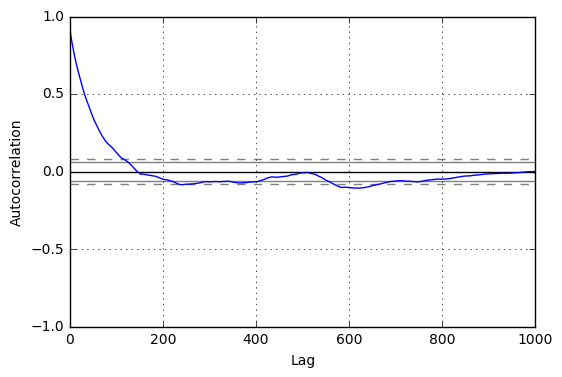

In [7]:
from pandas.tools.plotting import autocorrelation_plot as acp
import matplotlib.pyplot as plt

def normalize(df): return (df - df.mean()) / df.std()
acp(normalize(arch_samples))

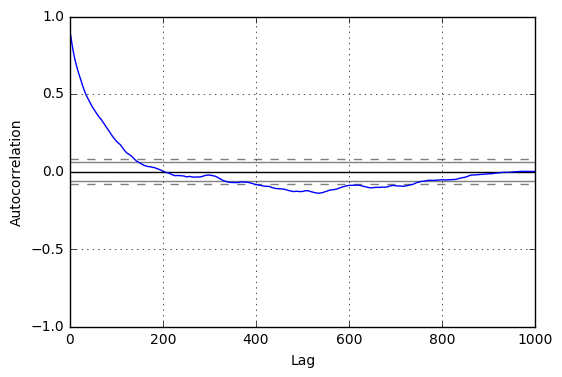

In [8]:
acp(normalize(optgp_samples))

We see that autocorrelation diminishes after 100 iterations, which is why the default thinning factor is 100. Thus, using the default contructors we get:

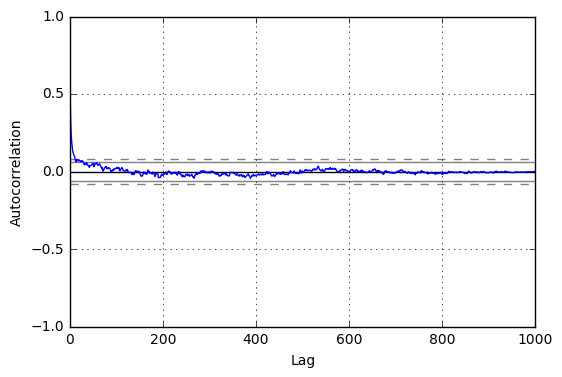

In [9]:
arch = ARCHSampler(mod)
arch_samples = arch.sample(1000)
arch_samples = pd.DataFrame(arch_samples, columns=[r.id for r in mod.reactions])
acp(normalize(arch_samples))

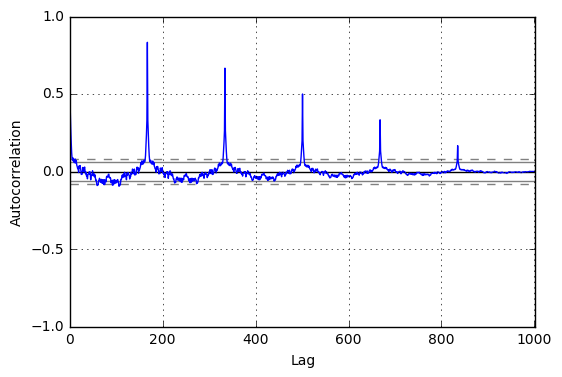

In [10]:
optgp = OptGPSampler(mod, 6)
optgp_samples = optgp.sample(1000)
optgp_samples = pd.DataFrame(optgp_samples, columns=[r.id for r in mod.reactions])
acp(normalize(optgp_samples))

OptGP samples one chain per process. This can be nicely seen in the autocorrelation function where we have a peak for each process. Those do not influence overall convergence since they quickly drop... This can be seen by plotting the trace which shows pretty much uniform sampling. Nevertheless, the preferred use case for OptGP is to sample large chains, meaning sampling many flux distributions for each batch.

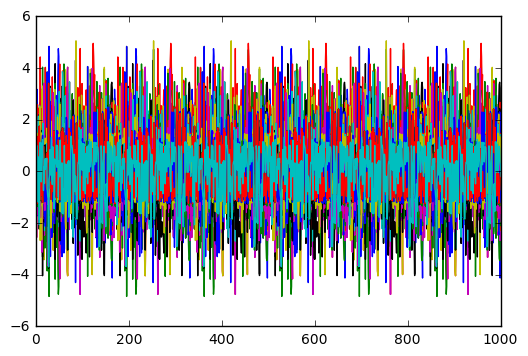

In [11]:
normalize(optgp_samples).plot(legend=False)

## Performance

Sampling itself obviously takes time, however there is also an initializiation overhead since the initial warmup points are generated from a set of 2 * n_r LP problems. 

### Small model

In [12]:
print(mod.id)
print(len(mod.metabolites), len(mod.reactions), sep=", ")

e_coli_core
72, 95


In [13]:
arch = %time ARCHSampler(mod)
t = %timeit -r1 -n1 -o arch.sample(1000)
print("Time per iteration = {:.2f} μs".format(t.worst / arch.thinning / 1000 * 1e6))
print("Time per sample = {:.2f} ms".format(t.worst / 1000 * 1e3))

CPU times: user 128 ms, sys: 148 ms, total: 276 ms
Wall time: 103 ms
1 loop, best of 1: 5.99 s per loop
Time per iteration = 59.91 μs
Time per sample = 5.99 ms


In [14]:
optgp = %time OptGPSampler(mod, 6)
t = %timeit -r1 -n1 -o optgp.sample(1000)
print("Time per iteration = {:.2f} μs".format(t.worst / arch.thinning / 1000 * 1e6))
print("Time per sample = {:.2f} ms".format(t.worst / 1000 * 1e3))

CPU times: user 56 ms, sys: 128 ms, total: 184 ms
Wall time: 45.7 ms
1 loop, best of 1: 1.74 s per loop
Time per iteration = 17.44 μs
Time per sample = 1.74 ms


This gives a speed up in the order of the number of cores I have in my machine (4 cores, 8 threads). However, in my case ARCHSampler also contributes from OpenBLAS which parallelizes linear algebra routines automatically which has an impact for larger models.

### Large model

In [15]:
from cobra.io import read_sbml_model
recon2 = read_sbml_model("/home/cdiener/Downloads/MODEL1603150001.xml")

print(recon2.id)
print(len(recon2.metabolites), len(recon2.reactions), sep=", ")

cobra/io/sbml.py:205 UserWarning: M_h_x appears as a reactant and product FAOXC220200x


MODEL1603150001
5324, 7785


In [16]:
arch = %time ARCHSampler(recon2)
t = %timeit -r1 -n1 -o arch.sample(100)
print("Time per iteration = {:.2f} ms".format(t.worst / arch.thinning / 100 * 1e3))
print("Time per sample = {:.2f} ms".format(t.worst / 100 * 1e3))

CPU times: user 17min 49s, sys: 1min 56s, total: 19min 45s
Wall time: 5min 10s
1 loop, best of 1: 43.6 s per loop
Time per iteration = 4.36 ms
Time per sample = 436.06 ms


In [18]:
optgp = %time OptGPSampler(recon2, 6)
t = %timeit -r1 -n1 -o optgp.sample(100)
print("Time per iteration = {:.2f} ms".format(t.worst / optgp.thinning / 100 * 1e3))
print("Time per sample = {:.2f} ms".format(t.worst / 100 * 1e3))

CPU times: user 17min 46s, sys: 2min 2s, total: 19min 48s
Wall time: 5min 11s
1 loop, best of 1: 25.7 s per loop
Time per iteration = 2.57 ms
Time per sample = 257.02 ms


Here, artificial centering is gaining grounds due to the optimization of linear algebra by OpenBlas (computation will actually use all of your CPUs in that case). On systems without an advanced BLAS library, the gap between OptGP and ARCH will become larger.